Variables of filenames

In [1]:
#PLAINTREE FILES NAMES
directory='/Users/julnow/gsi/inz/jupyter/'
fileName = directory + 'PlainTree2.5M_ml_DCM_12gev.root'
# fileName = directory + 'PlainTree10k_ml_DCM_12gev.root'
fileNameTest = directory + 'PlainTree1M_ml_URQMD_12gev.root'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#from hipe4ml.model_handler import ModelHandler
#from hipe4ml.tree_handler import TreeHandler
from matplotlib.patches import ConnectionPatch
from matplotlib.backends.backend_pdf import PdfPages
#from hipe4ml import plot_utils

import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz

from sklearn.model_selection import cross_val_score
import scipy
from scipy.stats import uniform

from numpy import sqrt, log, argmax

import weakref 
import itertools

from CBM_ML import tree_importer,  KFPF_lambda_cuts, plot_tools
from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer

import gc, os
from enum import Enum

In [3]:
#CUTS USED FOR DATA CLEANING
#momentums cuts
pzLowerCut = 0
pUpperCut = 12
ptUpperCut = 2
#time
tUpperCut = 40
#pid codes of particles
class Pid(Enum):
    ELECTRON = 11
    POSITRON = -11
    PROTON = 2212 
    NEG_MUON = -13
    POS_MUON = 13
    NEG_PION = -211
    POS_PION = 211 
    NEG_KAON = -321
    POS_KAON = 321 
    GHOST = -999
    @classmethod
    def is_known_particle(cls, value):
        return value in cls._value2member_map_ 
    
def clean_df(df, info = 0):
    # let's treat all the infinite, inf, values by nan and then we drop all the null entries
    with pd.option_context('mode.use_inf_as_na', True):
        df = df.dropna()
    #Experimental constraints
    #pz
    size_pz =  len(df['pz'])
    is_good_pz = (df['pz'] > pzLowerCut)
    percentage_pz = ( size_pz - len(df[is_good_pz]) ) / size_pz
    #p
    size_p =  len(df['p'])
    is_good_p = (df['p'] < pUpperCut)
    percentage_p = ( size_p - len(df[is_good_p]) ) / size_p
    #p
    size_pt =  len(df['pT'])
    is_good_pt = (df['pT'] < ptUpperCut)
    percentage_pt = ( size_pt - len(df[is_good_pt]) ) / size_pt
    #t
    size_t =  len(df['t'])
    is_good_t = (df['t'] < tUpperCut)
    percentage_t = ( size_t - len(df[is_good_t]) ) / size_t
    is_good_df = (is_good_pz) & (is_good_p) & (is_good_pt) & (is_good_t)
    if (info == 1):
        print('with the pz selection criteria we lose we loose ' + str(round(percentage_pz*100, 4)) + '% of entries')
        print('with the p selection criteria we lose we loose ' + str(round(percentage_p*100, 4)) + '% of entries')
        print('with the pT selection criteria we lose we loose ' + str(round(percentage_pt*100, 4)) + '% of entries')
        print('with the t selection criteria we lose we loose ' + str(round(percentage_t*100, 4)) + '% of entries')

    return df[is_good_df]
def downsample(df:pd.DataFrame, label_col_name:str) -> pd.DataFrame:
    # find the number of observations in the smallest group
    nmin = df[label_col_name].value_counts().min()
    return (df
            # split the dataframe per group
            .groupby(label_col_name)
            # sample nmin observations from each group
            .apply(lambda x: x.sample(nmin))
            # recombine the dataframes
            .reset_index(drop=True)
            )

To import the root files with simulated data as PlainTrees into Panda's dataframes format we use the function from **CBM_ML_LAMBDA_LIBRARY** prepared by Shahid.

In [4]:
%%capture
#Shahid's library for importing roottrees
!git clone https://github.com/shahidzk1/CBM_ML_Lambda_Library.git
%cd CBM_ML_Lambda_Library
!git pull origin main
!pip install -r requirements.txt
!python setup.py install
from CBM_ML import tree_importer, plot_tools, KFPF_lambda_cuts

In [5]:
# We import three root files into our jupyter notebook
particles = tree_importer.tree_importer(fileName,'plain_tree',7)
particles.columns = particles.columns.str.replace('Complex_', '')
gc.collect()

particles.iloc[0:10,:]

,eta,l,mass,p,pT,phi,px,py,pz,rapidity,t,pid,q
0,1.772989,726.968933,0.938272,3.081436,1.017269,-2.501104,-0.815650,-0.607907,2.908679,1.488253,25.257862,2212.0,1.0
1,2.434091,789.583557,0.938272,2.045768,0.355999,-1.127488,0.152699,-0.321587,2.014555,1.446963,26.548641,2212.0,1.0
2,1.923849,794.463928,0.139570,0.925076,0.264560,-2.625532,-0.230107,-0.130549,0.886438,1.806840,26.454737,211.0,1.0
3,2.448442,753.877502,0.938272,8.301641,1.424350,-0.910986,0.873079,-1.125392,8.178537,2.271433,25.385580,2212.0,1.0
4,2.299000,752.853638,0.938272,1.316773,0.261665,-2.482023,-0.206782,-0.160342,1.290513,1.093517,25.362499,2212.0,1.0
5,2.859857,763.913025,0.938272,3.449825,0.393898,-1.800607,-0.089727,-0.383542,3.427263,1.928807,27.897562,2212.0,1.0
6,2.885593,763.653015,0.139570,1.869297,0.208047,-1.574484,-0.000767,-0.208045,1.857684,2.701191,25.378315,-211.0,1.0
7,2.840546,747.993958,0.139570,2.500303,0.291011,-1.223433,0.099066,-0.273630,2.483310,2.737813,25.116238,211.0,1.0
8,3.017349,793.801025,0.000511,6.246289,0.609811,-1.780552,-0.126976,-0.596445,6.216451,3.017349,26.594879,11.0,1.0
9,3.101090,794.461365,0.938272,6.787242,0.609614,-1.850472,-0.168281,-0.585928,6.759809,2.498553,28.626184,2212.0,1.0


In [6]:
#we'll set other particles to one pid code (ghost)
for particle in particles['pid'].unique():
    if not Pid.is_known_particle(particle):
         particles.replace(particle, Pid.GHOST.value, inplace=True)              
#downsampling the data
print('number of particles before downsampling : ' + str(len(particles)))
particles = downsample(particles, 'pid')
particles.iloc[0:10,:]

#let's add velocity field
particles['v'] = particles['l']/particles['t']
particles = clean_df(particles)

#changing ids to (0, nmb] for xgboost training
i = 0
for particle in Pid:
    particles['pid'].replace(particle.value, i, inplace=True)
    i += 1
print('number of particles after downsampling : ' + str(len(particles)))
print('number of particles per class : ' + str(len(particles)/len(Pid)))
gc.collect()

number of particles before downsampling : 117341523
number of particles after downsampling : 4575575
number of particles per class : 457557.5


0

In [7]:
gc.collect()

0

In [8]:
# The following columns will be used to predict whether a reconstructed candidate is a lambda particle or not
params = [ 'p', 'pT', 'eta', 'v', 'q'] 
x = particles[params].copy()

# The MC information is saved in this y variable
y =pd.DataFrame(particles['pid'], dtype='int')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=324)
del particles, x, y

#DMatrix is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed. 
dtrain = xgb.DMatrix(x_train, label = y_train, weight=[.5, .5, .5, .5, 1])
# dtest1=xgb.DMatrix(x_test, label = y_test)
# del x_test
gc.collect()

9

In [9]:
def bo_tune_xgb(max_depth, gamma, alpha,learning_rate):
    params = {'max_depth': int(max_depth),
              'gamma': gamma,
              'alpha':alpha,
              'learning_rate':learning_rate,
              'subsample': 0.8,
              'eta': 0.3,
              'num_class':np.unique(dtrain.get_label()).shape[0],
              'objective':'multi:softprob', 
              'eval_metric': 'mlogloss','tree_method':'hist', 'nthread' : 7}
    cv_result = xgb.cv(params=params, dtrain=dtrain, num_boost_round=10, nfold=5)
    return cv_result['test-mlogloss-mean'].iloc[-1]
bounds_transformer = SequentialDomainReductionTransformer()
#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (4, 10),
                                             'alpha': (2,12),
                                             'gamma': (0, 1),
                                             'learning_rate':(0.01,1),
                                            },
                              bounds_transformer=bounds_transformer)

#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an #acquisition function of expected improvement
xgb_bo.maximize(n_iter=5, init_points=5, acq='ei')

|   iter    |  target   |   alpha   |   gamma   | learni... | max_depth |
-------------------------------------------------------------------------
|  1        |  nan      |  3.932    |  0.5597   |  0.9067   |  8.267    |


KeyboardInterrupt: 

In [ ]:
print(xgb_bo.max['params'])

In [10]:
# max_param = xgb_bo.max['params']
max_param = {'alpha': 5.487233473672837, 'gamma': 0.9620785521972597, 
             'learning_rate': 0.03439635460444924, 'max_depth': 8.845996139265273}
param= {'alpha': max_param['alpha'], 'gamma': max_param['gamma'], 'learning_rate': max_param['learning_rate'],
        'max_depth': int(round(max_param['max_depth'],0)), 'num_class':np.unique(dtrain.get_label()).shape[0],
         'objective':'multi:softprob','eval_metric': 'mlogloss', 'tree_method':'hist','nthread' : 7}

#Fit/train on training data
bst = xgb.XGBClassifier(**param).fit(x_train, y_train)

#predicitions on training set
bst_train= pd.DataFrame(data=bst.predict_proba(x_train))
y_train=y_train.set_index(np.arange(0,bst_train.shape[0]))
bst_train['xgb_preds']=bst_train.iloc[:,0:(len(bst_train.columns)-1)].idxmax(axis = 1)
bst_train['pid']=y_train['pid']

bst_test = pd.DataFrame(data=bst.predict_proba(x_test))
bst_test['xgb_preds']=bst_test.iloc[:,0:(len(bst_test.columns)-1)].idxmax(axis = 1)
y_test=y_test.set_index(np.arange(0,bst_test.shape[0]))
bst_test['pid']=y_test['pid']

/opt/homebrew/Caskroom/miniforge/base/envs/cbm21/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/cbm21/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


## Another set
We also select the selected variables from the 10k events data set

In [11]:
# We import three root files into our jupyter notebook
particlesTest = tree_importer.tree_importer(fileNameTest,'plain_tree',7)
particlesTest.columns = particlesTest.columns.str.replace('Complex_', '')
# bckgr = bckgr[(bckgr['Candidates_generation'] < 1)
#                  & ((bckgr['Candidates_mass'] > lower5SigmaCutBckgr)
#                  & (bckgr['Candidates_mass'] < lower5SigmaCutSign) | (bckgr['Candidates_mass']>upper5SigmaCutSign) 
gc.collect()
#let's add velocity field
particlesTest['v'] = particlesTest['l']/particlesTest['t']
particlesTest = clean_df(particlesTest)
#we'll set other particles to one pid code (ghost)
for particle in particlesTest['pid'].unique():
    if not Pid.is_known_particle(particle):
         particlesTest.replace(particle, Pid.GHOST.value, inplace=True)
#changing ids to (0. nmb] for xgboost training
i = 0
for particle in Pid:
    particlesTest['pid'].replace(particle.value, i, inplace=True)
    i += 1
particlesTest.iloc[0:10,:]

,eta,l,mass,p,pT,phi,px,py,pz,rapidity,t,pid,q,v
0,2.795109,796.765564,0.139570,3.360802,0.409217,-1.931746,-0.144520,-0.382848,3.335796,2.740521,26.631847,5.0,-1.0,29.917772
1,2.862100,797.093079,0.493677,2.920601,0.332732,-1.740885,-0.056321,-0.327931,2.901586,2.287393,26.975466,8.0,1.0,29.548817
2,2.025051,785.335205,0.938272,2.650691,0.687733,-2.986821,-0.679512,-0.106017,2.559919,1.529873,27.855837,2.0,1.0,28.192842
3,1.962085,745.262451,0.938272,3.123042,0.860970,-0.086505,0.857751,-0.074385,3.002019,1.592940,25.919329,2.0,1.0,28.753155
4,2.162448,734.718689,0.139570,2.821904,0.640801,0.066599,0.639381,0.042645,2.748184,2.139893,24.501303,5.0,-1.0,29.986923
5,3.121445,792.576599,0.938272,6.939540,0.610784,1.233429,0.202172,0.576353,6.912608,2.520050,26.742485,2.0,1.0,29.637358
6,2.217318,759.005249,0.938272,2.472587,0.532222,2.700255,-0.481225,0.227338,2.414628,1.545454,27.027834,2.0,1.0,28.082355
7,2.333610,749.677795,0.139570,3.696914,0.710121,2.618707,-0.615236,0.354622,3.628071,2.315019,25.072449,6.0,1.0,29.900461
8,2.156020,733.076660,0.139570,5.610508,1.282038,0.950416,0.745306,1.043139,5.462068,2.150286,24.501919,5.0,1.0,29.919153
9,2.211525,769.359009,0.139570,1.712385,0.370680,1.318592,0.092499,0.358953,1.671783,2.146911,25.997503,5.0,1.0,29.593573


In [12]:
x_whole = particlesTest[params].copy()
y_whole = pd.DataFrame(particlesTest['pid'], dtype='int')

whole_test= pd.DataFrame(data=bst.predict_proba(x_whole))
y_whole=y_whole.set_index(np.arange(0,whole_test.shape[0]))
whole_test['xgb_preds']=whole_test.iloc[:,0:(len(whole_test.columns)-1)].idxmax(axis = 1)
whole_test['pid']=y_whole['pid']
gc.collect()

9

In [13]:
whole_test

,0,1,2,3,4,5,6,7,8,9,xgb_preds,pid
0,0.126540,0.107211,0.035143,0.116447,0.129337,0.197238,0.157093,0.046750,0.059903,0.024337,5,5
1,0.070839,0.028737,0.105729,0.098995,0.102151,0.071984,0.076586,0.172225,0.224200,0.048555,8,8
2,0.064515,0.022616,0.290475,0.035674,0.033816,0.022576,0.023839,0.136344,0.134029,0.236116,2,2
3,0.069906,0.024672,0.244324,0.050288,0.052208,0.031718,0.031188,0.149143,0.146170,0.200383,2,2
4,0.160773,0.188167,0.026122,0.097652,0.115969,0.184937,0.138238,0.030799,0.034212,0.023131,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
42470554,0.086170,0.030789,0.162448,0.127180,0.135954,0.110282,0.095795,0.099984,0.111048,0.040348,2,6
42470555,0.059357,0.024420,0.176286,0.034251,0.031324,0.022930,0.022402,0.134259,0.128757,0.366014,2,5
42470556,0.147996,0.213652,0.030806,0.109663,0.109239,0.145902,0.142725,0.037177,0.039334,0.023506,1,1
42470557,0.057214,0.025530,0.159644,0.047897,0.054595,0.025718,0.028163,0.133849,0.129700,0.337690,2,2


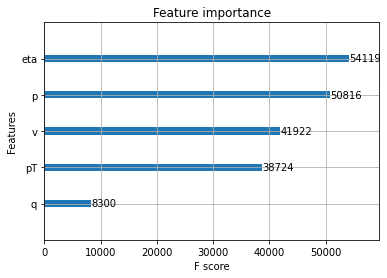

In [14]:
#The following graph will show us that which features are important for the model
ax = xgb.plot_importance(bst)
plt.rcParams['figure.figsize'] = [5, 3]
plt.show()
ax.figure.tight_layout() 
# ax.figure.savefig(directory+'img/xgb_12agev/chi2geo/feature_importance.pdf')
# ax.figure.savefig(directory+'img/xgb_12agev/chi2geo/feature_importance.png')

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 15)
    plt.xlabel('Predicted label',fontsize = 15)

Normalized confusion matrix
[[7.23e-05 3.49e-01 1.41e-01 4.76e-02 6.73e-02 7.71e-02 1.57e-01 8.51e-02
  7.59e-02 0.00e+00]
 [1.07e-04 7.15e-01 2.96e-02 1.51e-02 1.78e-02 6.33e-02 1.26e-01 1.85e-02
  1.51e-02 0.00e+00]
 [2.10e-05 2.72e-02 4.64e-01 4.51e-02 7.03e-02 2.59e-02 6.33e-02 1.66e-01
  1.38e-01 0.00e+00]
 [5.20e-05 1.92e-01 6.98e-02 9.40e-02 1.24e-01 8.64e-02 2.10e-01 1.17e-01
  1.07e-01 0.00e+00]
 [6.26e-05 1.85e-01 6.77e-02 8.84e-02 1.36e-01 1.00e-01 1.92e-01 1.21e-01
  1.10e-01 0.00e+00]
 [8.73e-05 2.86e-01 3.25e-02 7.03e-02 1.03e-01 1.26e-01 2.32e-01 7.65e-02
  7.40e-02 0.00e+00]
 [7.52e-05 2.95e-01 3.28e-02 7.53e-02 9.29e-02 1.03e-01 2.56e-01 7.25e-02
  7.17e-02 0.00e+00]
 [2.19e-05 4.90e-02 2.35e-01 6.16e-02 9.41e-02 4.55e-02 1.00e-01 2.39e-01
  1.75e-01 0.00e+00]
 [3.45e-05 6.69e-02 2.12e-01 6.45e-02 9.61e-02 5.07e-02 1.34e-01 1.79e-01
  1.96e-01 0.00e+00]
 [0.00e+00 1.79e-01 2.94e-01 4.48e-02 7.11e-02 5.84e-02 1.29e-01 1.26e-01
  9.80e-02 0.00e+00]]


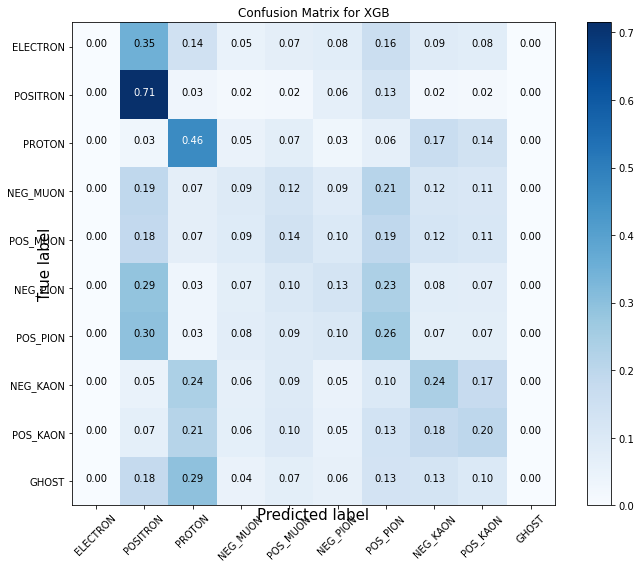

In [16]:
classes = []
for particle in Pid:
    classes.append(str(particle).replace('Pid.', ''))
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(y_whole, whole_test['xgb_preds'])#, labels=[1,0])
np.set_printoptions(precision=2)
fig, axs = plt.subplots(figsize=(10, 8))
axs.yaxis.set_label_coords(-0.04,.5)
axs.xaxis.set_label_coords(0.5,-.005)
plot_confusion_matrix(cnf_matrix, classes=classes, title='Confusion Matrix for XGB', normalize=True)
# fig.savefig(directory+'img/xgb_12agev/chi2geo/confusion_matrix_extreme_gradient_boosting_whole_data.pdf')
# fig.savefig(directory+'img/xgb_12agev/chi2geo/confusion_matrix_extreme_gradient_boosting_whole_data.png')